# Partie sur la prediction des données

## Classification des elections du second tour 2022

### Bibliotheque 

In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

### Préparation des données

In [2]:
#Preparation des données pour les entrainements

df_concat = pd.read_excel('Commune.xlsx')
    
# Sélection des features
features = df_concat.drop(['COM','Macron', 'Lepen', 'Abstentions'], axis=1)
y = [0 if x <= 50 else 1 for x in df_concat['Macron']]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

### Selection des Colonnes intéressante 

In [3]:
import statsmodels.api as sm

#creation de l'analyse pour la p_value
features_with_const = sm.add_constant(X_scaled)
logit_model = sm.Logit(y, features_with_const)
result = logit_model.fit()
#print(result.summary())

#Selection des p_value interessant
significant_indices = np.where(result.pvalues < 0.05)[0]
significant_indices =significant_indices[1:] - 1
#print(significant_indices)
significant_data = X_scaled[:, significant_indices]
print("Affichage des colonnes selectionné : ",features.iloc[:, significant_indices].columns)

#Affichage des nouveaux données
"""features_with_const = sm.add_constant(significant_data)
logit_model = sm.Logit(y, features_with_const)
result = logit_model.fit()
print(result.summary())"""

#division des données
X_train, X_test, y_train, y_test = train_test_split(significant_data, y, test_size=0.2, random_state=42)

#definition des labels
target_names = ['Lepen', 'Macron']

Optimization terminated successfully.
         Current function value: 0.198115
         Iterations 9
Affichage des colonnes selectionné :  Index(['MACRON', 'LASSALLE', 'LEPEN', 'ZEMMOUR', 'MÉLENCHON', 'HIDALGO',
       'JADOT', 'PÉCRESSE', 'DUPONT-AIGNAN', 'Macron17', 'Lepen17',
       'P20_HNSCOL15P_BAC', 'P20_FNSCOL15P_BEPC', 'P20_FNSCOL15P_BAC',
       'P20_FNSCOL15P_SUP5', 'PopTotal', 'RevenueCommune'],
      dtype='object')


### Application de SVM, en faisant du copier coller du tp8

In [4]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

# Prédire sur les données de test et évaluer les performances
y_pred_linear = svm_linear.predict(X_test)
print("Performance du SVM avec un noyau linéaire :")
print(classification_report(y_test, y_pred_linear, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred_linear)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred_linear))

Performance du SVM avec un noyau linéaire :
              precision    recall  f1-score   support

       Lepen       0.92      0.93      0.92      3297
      Macron       0.92      0.91      0.92      2975

    accuracy                           0.92      6272
   macro avg       0.92      0.92      0.92      6272
weighted avg       0.92      0.92      0.92      6272

Corrélation entre les valeurs réelles et prédites : 0.840419962196131
P-value associée : 0.0
R-value : 0.680919195703759


In [5]:
svm_linear = SVC(kernel='poly')
svm_linear.fit(X_train, y_train)

# Prédire sur les données de test et évaluer les performances
y_pred_linear = svm_linear.predict(X_test)
print("Performance du SVM avec un noyau linéaire :")
print(classification_report(y_test, y_pred_linear, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred_linear)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred_linear))

Performance du SVM avec un noyau linéaire :
              precision    recall  f1-score   support

       Lepen       0.89      0.94      0.91      3297
      Macron       0.93      0.87      0.90      2975

    accuracy                           0.91      6272
   macro avg       0.91      0.91      0.91      6272
weighted avg       0.91      0.91      0.91      6272

Corrélation entre les valeurs réelles et prédites : 0.8140873232158765
P-value associée : 0.0
R-value : 0.6265667540901709


In [6]:
#trop lent car fait toutes les combinaisons

"""from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)
print("Meilleurs paramètres pour SVM:", grid_search.best_params_)
print("Performance du SVM avec les meilleurs paramètres :")
print(classification_report(y_test, y_pred_best, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred_linear)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred_linear))

"""

'from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\'C\': [0.1, 1, 10, 100], \'gamma\': [0.001, 0.01, 0.1, 1]}\ngrid_search = GridSearchCV(SVC(), param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\nbest_svm = grid_search.best_estimator_\ny_pred_best = best_svm.predict(X_test)\nprint("Meilleurs paramètres pour SVM:", grid_search.best_params_)\nprint("Performance du SVM avec les meilleurs paramètres :")\nprint(classification_report(y_test, y_pred_best, target_names=target_names))\n\ncorrelation, p_value = pearsonr(y_test, y_pred_linear)\nprint("Corrélation entre les valeurs réelles et prédites :", correlation)\nprint("P-value associée :", p_value)\nprint("R-value :", r2_score(y_test, y_pred_linear))\n\n'

### Application de Regression

In [7]:
# régression logistique
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred))

              precision    recall  f1-score   support

       Lepen       0.92      0.93      0.92      3297
      Macron       0.92      0.91      0.92      2975

    accuracy                           0.92      6272
   macro avg       0.92      0.92      0.92      6272
weighted avg       0.92      0.92      0.92      6272

Corrélation entre les valeurs réelles et prédites : 0.840100067447813
P-value associée : 0.0
R-value : 0.6802797552141875


In [8]:
# Classifier using Ridge regression
from sklearn.linear_model import RidgeClassifier

ridgeClf = RidgeClassifier()
ridgeClf.fit(X_train, y_train)

y_pred = ridgeClf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred))

              precision    recall  f1-score   support

       Lepen       0.91      0.93      0.92      3297
      Macron       0.92      0.90      0.91      2975

    accuracy                           0.91      6272
   macro avg       0.91      0.91      0.91      6272
weighted avg       0.91      0.91      0.91      6272

Corrélation entre les valeurs réelles et prédites : 0.8292302026842071
P-value associée : 0.0
R-value : 0.6585387785687522


In [9]:
from sklearn.linear_model import SGDClassifier
#Linear classifiers (SVM, logistic regression, etc.) with SGD training.

sgdClf = SGDClassifier()
sgdClf.fit(X_train, y_train)

y_pred = sgdClf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred))

              precision    recall  f1-score   support

       Lepen       0.92      0.92      0.92      3297
      Macron       0.91      0.91      0.91      2975

    accuracy                           0.91      6272
   macro avg       0.91      0.91      0.91      6272
weighted avg       0.91      0.91      0.91      6272

Corrélation entre les valeurs réelles et prédites : 0.829228242141193
P-value associée : 0.0
R-value : 0.6585387785687522


### Application de Foret aléatoire

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement d'une forêt aléatoire
forest_model = RandomForestClassifier(n_estimators=1000, random_state=42)
forest_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_forest = forest_model.predict(X_test)

print(classification_report(y_test, y_pred_forest, target_names=target_names))

correlation, p_value = pearsonr(y_test, y_pred_forest)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred_forest))

              precision    recall  f1-score   support

       Lepen       0.92      0.92      0.92      3297
      Macron       0.91      0.91      0.91      2975

    accuracy                           0.92      6272
   macro avg       0.92      0.92      0.92      6272
weighted avg       0.92      0.92      0.92      6272

Corrélation entre les valeurs réelles et prédites : 0.8311456707550378
P-value associée : 0.0
R-value : 0.6623754215061819


### Reseau de neuronne

In [11]:
import tensorflow as tf
from tensorflow.keras import optimizers, losses, callbacks
import numpy as np

X_trainNN = np.array(X_train)
y_trainNN = np.array(y_train)
X_valNN, X_testNN = train_test_split(X_test, test_size=0.5, random_state=42)
y_valNN, y_testNN = train_test_split(y_test, test_size=0.5, random_state=42)

X_valNN = np.array(X_valNN)
y_valNN = np.array(y_valNN)

X_testNN = np.array(X_testNN)
y_testNN = np.array(y_testNN)

CallBackSave = callbacks.ModelCheckpoint("best_model_classification.keras", 
                                         monitor='val_loss', 
                                         save_best_only=True, 
                                         mode='min')

callbackStop = callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=70)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(features.shape[1], activation='relu'),
    tf.keras.layers.Dense(int(features.shape[1]*3/4), activation='relu'),
    tf.keras.layers.Dense(int(features.shape[1]/2), activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=losses.binary_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])     

history = model.fit(X_trainNN, y_trainNN,
                    epochs=1000,validation_data=(X_valNN, y_valNN),
                    callbacks=[CallBackSave,callbackStop]
                   )


Epoch 1/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 2s 777us/step - accuracy: 0.8822 - loss: 0.2900 - val_accuracy: 0.9200 - val_loss: 0.1904
Epoch 2/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.9133 - loss: 0.1996 - val_accuracy: 0.9177 - val_loss: 0.1849
Epoch 3/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.9195 - loss: 0.1905 - val_accuracy: 0.9142 - val_loss: 0.1900
Epoch 4/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.9170 - loss: 0.1914 - val_accuracy: 0.9174 - val_loss: 0.1836
Epoch 5/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.9155 - loss: 0.1919 - val_accuracy: 0.9203 - val_loss: 0.1840
Epoch 6/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.9217 - loss: 0.1830 - val_accuracy: 0.9212 - val_loss: 0.1876
Epoch 7/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.9220 - loss: 0.1823 - val_accuracy: 0.9139 - val_loss: 0.1916
Epoch 8/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9182 - l

784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9489 - loss: 0.1277 - val_accuracy: 0.9059 - val_loss: 0.2408
Epoch 51/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.9474 - loss: 0.1291 - val_accuracy: 0.9075 - val_loss: 0.2443
Epoch 52/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.9472 - loss: 0.1310 - val_accuracy: 0.9034 - val_loss: 0.2430
Epoch 53/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.9484 - loss: 0.1262 - val_accuracy: 0.9056 - val_loss: 0.2433
Epoch 54/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.9500 - loss: 0.1214 - val_accuracy: 0.9021 - val_loss: 0.2527
Epoch 55/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9503 - loss: 0.1219 - val_accuracy: 0.9040 - val_loss: 0.2571
Epoch 56/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9472 - loss: 0.1258 - val_accuracy: 0.9043 - val_loss: 0.2477
Epoch 57/1000
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9469 - loss: 0

In [33]:
best_model = tf.keras.models.load_model("best_model_classification.keras")

y_pred_NN = best_model.predict(X_testNN)
y_pred_binary = (y_pred_NN > 0.5).astype(int)
print(classification_report(y_testNN, y_pred_binary, target_names=target_names))

correlation, p_value = pearsonr(y_testNN, y_pred_binary.flatten())
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_testNN, y_pred_binary))

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
              precision    recall  f1-score   support

       Lepen       0.91      0.93      0.92      1626
      Macron       0.92      0.90      0.91      1510

    accuracy                           0.92      3136
   macro avg       0.92      0.91      0.91      3136
weighted avg       0.92      0.92      0.92      3136

Corrélation entre les valeurs réelles et prédites : 0.8301568286014447
P-value associée : 0.0
R-value : 0.6602494236862899


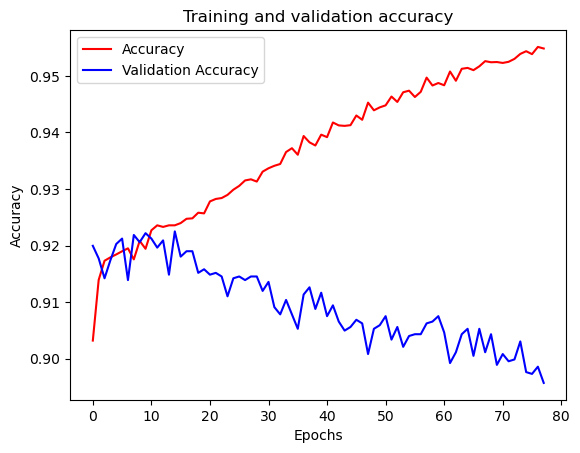

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = [*range(len(acc))]

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

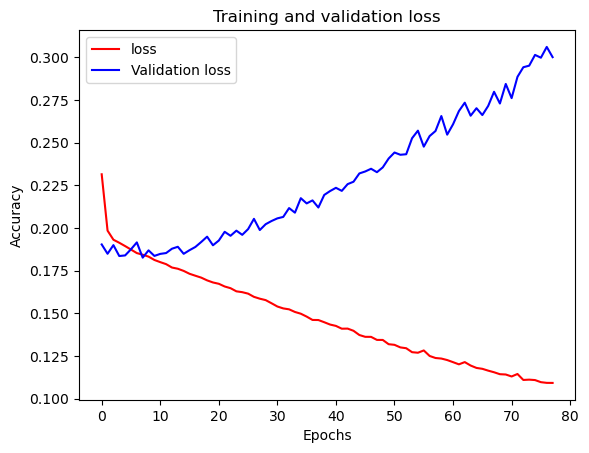

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [*range(len(loss))]

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["loss", "Validation loss"])
plt.show()

### KNN voisin

In [24]:
from sklearn.neighbors import KNeighborsClassifier

acc=0
bestN_neighbors=1

X_valKNN, X_testKNN = train_test_split(X_test, test_size=0.5, random_state=42)
y_valKNN, y_testKNN = train_test_split(y_test, test_size=0.5, random_state=42)


for i in range (1,int(X_testKNN.shape[0]/4),25):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train, y_train)
    
    y_pred = knn_model.predict(X_valKNN)
    matriceConfusion = classification_report(y_valKNN, y_pred, output_dict=True)
    
    precision_class_0 = matriceConfusion['0']['precision']
    precision_class_1 = matriceConfusion['1']['precision']
    
    avg_precision = (precision_class_0 + precision_class_1) / 2
    
    if avg_precision > acc:
        bestN_neighbors = i
        acc = avg_precision
        print(bestN_neighbors, " : ", acc)
        
knn_model = KNeighborsClassifier(n_neighbors=bestN_neighbors)
knn_model.fit(X_train, y_train)
    
y_pred = knn_model.predict(X_testKNN)
print(classification_report(y_testKNN, y_pred, target_names=target_names))

correlation, p_value = pearsonr(y_testKNN, y_pred)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_testKNN, y_pred))

1  :  0.8673754697664959
26  :  0.9122488480771277
              precision    recall  f1-score   support

       Lepen       0.90      0.92      0.91      1626
      Macron       0.91      0.89      0.90      1510

    accuracy                           0.91      3136
   macro avg       0.91      0.91      0.91      3136
weighted avg       0.91      0.91      0.91      3136

Corrélation entre les valeurs réelles et prédites : 0.8128833152749432
P-value associée : 0.0
R-value : 0.6257634629326427


### LCA

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)

y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
correlation, p_value = pearsonr(y_test, y_pred)
print("Corrélation entre les valeurs réelles et prédites :", correlation)
print("P-value associée :", p_value)
print("R-value :", r2_score(y_test, y_pred))

              precision    recall  f1-score   support

       Lepen       0.91      0.93      0.92      3297
      Macron       0.92      0.90      0.91      2975

    accuracy                           0.92      6272
   macro avg       0.92      0.91      0.91      6272
weighted avg       0.92      0.92      0.91      6272

Corrélation entre les valeurs réelles et prédites : 0.8295491330582265
P-value associée : 0.0
R-value : 0.6591782190583237


### PCA

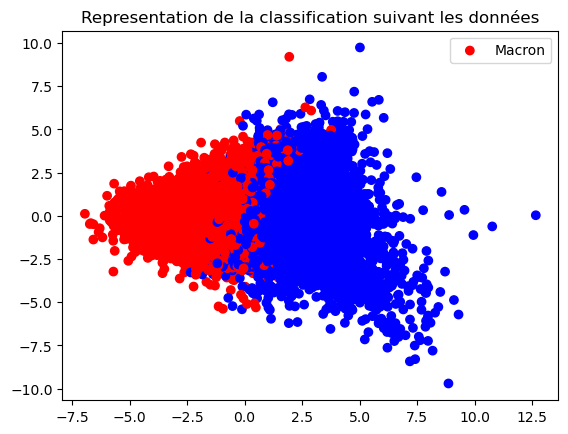

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)


plt.figure()

plt.scatter(X_pca[:,0], X_pca[:,1], color=['red' if x <= 0.5 else 'blue' for x in y_train])
plt.title('Representation de la classification suivant les données')
plt.legend(['Macron', 'Le Pen'])
plt.show()